## Import important packages

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import scipy.constants as cs

## Load and present the data

First we need to load the data from 'rabispectrum.txt'. To see the structure of the data, we can to this by a "magic" Jupyter notebook command %load:

We see that we need to skip the first row of the data, that the data are delimited by tabs, and that we have two columns representing the *frequency* and the *transfer fraction*.

In [2]:
filename = 'rabispectrum.txt'
freq, fraction= np.loadtxt(filename,skiprows=1,unpack=True) #The function should automatically deal with a delimiter.

Let's show the data:

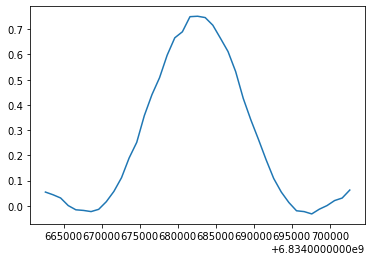

In [3]:
fig,ax = plt.subplots()
ax.plot(freq,fraction)

Now that we have a rough idea of what the data set looks like, let's start to improve the formatting of the figure:

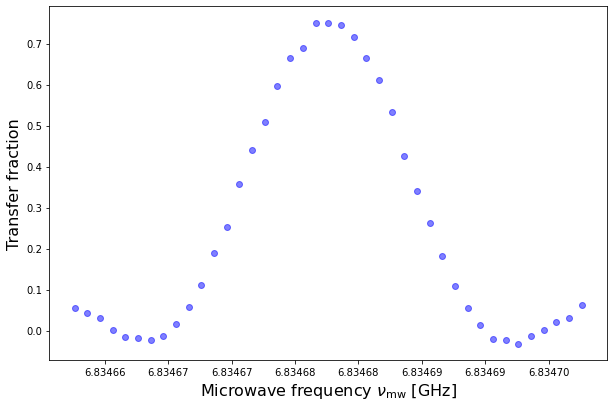

In [4]:
#Make a figure a bit bigger:
fig,ax = plt.subplots(figsize=(10,6.5))

# Turn the frequency data into GHz by dividing by 1e9, and use blue circular markers ('bo'):
ax.plot(freq/1e9,fraction,'bo',alpha=0.5) # alpha = 0.5 sets the opacity of the markers

#Labels using latex:
ax.set_ylabel(r'Transfer fraction',size=16)
ax.set_xlabel(r'Microwave frequency $\nu_\mathrm{mw}$ [GHz]',size=16) #The r before the string sets to math mode

#Format x-axis:
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))

#Show the plot:
plt.show()

## Fit the data

The theoretical model for the transfer fraction $P_f$ as a function of microwave frequency $\nu$ is: $$P_f = \frac{\mathcal{F}^2}{\mathcal{F}^2 + \delta^2} \sin^2 \left ( \pi \sqrt{\mathcal{F}^2 + \delta^2} t \right).$$  Here, $\mathcal{F}$ is the Rabi frequency, which depends on the strength of the microwave field, $\delta = \nu_0 - \nu_{mw}$ is the detuning of the microwave field from the $|b\rangle\rightarrow|f\rangle$ transition, and $t$ is the duration of the microwave pulse.  Based on this model, let's define a Python function *frac* which will be used for fitting.  (*frac* represents the transfer fraction $P_f$.)

In [5]:
# f is the v_mw microwave frequency and f_0 is the v_0 reference frequency, F is the rabi frequency
def frac(f,F,f_0):
    d = f-f_0#detuning
    t=60e-6 #length of the Rabi pulse
    return (F**2/(F**2+d**2))*(np.sin(cs.pi*np.sqrt(F**2+d**2)*t))**2

Now let's apply the curve-fitting routine *curve_fit* from the *scipy.optimize* library to determine the **fit parameters** and their **statistical uncertainties**.  (Next week in class, we will discuss what is going on behind the scenes in performing non-linear curve fitting.  For now, you may think of the *curve_fit* function as a black box.)

In [6]:
# Fit using the initial guesses specified by p0 - list of parameters.
# Curvefit returns a vector of fit parameters and a covariance matrix.
# Diagonal elemements of the covariance matrix represent (squared) statistical uncertainties of the fit parameters,
# while off-diagonal elements quantify how strongly the statistical errors are correlated.
# frac is function of the independant variable + coefficients
# freq is x data, the frequency from the rabi data
# fraction is the fraction in the rabi data
coefs0, covar0 = curve_fit(frac, freq, fraction, p0=[8.5e3,6.83469e9])
# Optimizes to find F, and f_0 such that the plot of frac(f) over f matches the data of rabi 

# Print the fitting parameter and its statistical uncertainty in pairs.
print("Fit parameters with statistical uncertainties:\n")
print([[coefs0[nn],np.sqrt(covar0[nn,nn])] for nn in range(len(coefs0))])
# Coefs0[0] is the found F = rabi frequency
# Coefs0[1] is the found f0 = reference frequency
# covar0[0] is squared stat uncertanty for freq = F = rabi frequency
# covar0[1] is squared stat uncertanty for fraction = f0 = reference frequency

Fit parameters with statistical uncertainties:

[[10598.229847233039, 123.70182370215522], [6834682644.037852, 169.91009405886908]]


In [7]:
f0_Hz = coefs0[1]
f0_GHz = f0_Hz * 1e-9
print(f"reference frequency f_0 is {f0_Hz} Hz = {f0_GHz} GHz")
f0_uncertainty_Hz = np.sqrt(covar0[1, 1])
f0_uncertainty_GHz = f0_uncertainty_Hz * 1e-9
print(f"reference frequency f_0 uncertainty (std) is {f0_uncertainty_Hz} Hz = {f0_uncertainty_GHz} GHz")

F_Hz = coefs0[0]
F_GHz = F_Hz * 1e-9
print(f"rabi frequency F is {F_Hz} Hz = {F_GHz} GHz")
F_uncertainty_Hz = np.sqrt(covar0[0, 0])
F_uncertainty_GHz = F_uncertainty_Hz * 1e-9
print(f"rabi frequency F uncertainty (std) is {F_uncertainty_Hz} Hz = {F_uncertainty_GHz} GHz")

reference frequency f_0 is 6834682644.037852 Hz = 6.834682644037852 GHz
reference frequency f_0 uncertainty (std) is 169.91009405886908 Hz = 1.699100940588691e-07 GHz
rabi frequency F is 10598.229847233039 Hz = 1.0598229847233039e-05 GHz
rabi frequency F uncertainty (std) is 123.70182370215522 Hz = 1.2370182370215524e-07 GHz


To plot the fit, let's first make an array *freq_fit* of evenly spaced frequency points:

In [8]:
freq_fit = np.linspace(coefs0[1]-20e3,coefs0[1]+20e3,100)#+-20kHz around the center frequency

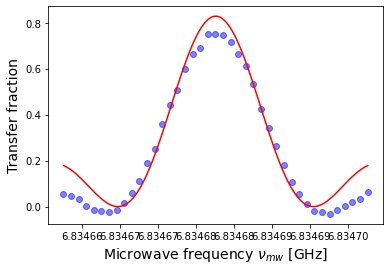

In [9]:
fig,ax = plt.subplots()

ax.plot(freq/1e9,fraction,'bo',alpha=0.5)
ax.plot(freq_fit/1e9,frac(freq_fit,*coefs0) ,'-r')

#Labels:
ax.set_ylabel('Transfer fraction',size=14)
ax.set_xlabel(r'Microwave frequency $\nu_{mw}$ [GHz]',size=14)

#Format x-axis:
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))

#Show the plot:
plt.show()

The fit doesn't look very good... You will improve it shortly.  First, though, let's make some improvements to our plot based on this first attempt at fitting.  In particular:
1. To make the frequency axis more readable, we will plot the transfer fraction vs. detuning $\delta = \nu_0-\nu_{mw}$.
2. We will annotate the plot with the fit parameters.

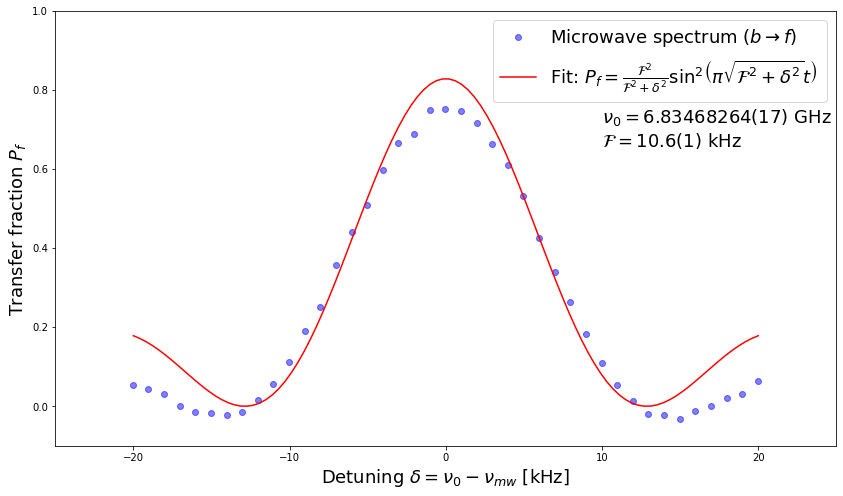

In [10]:
fig,ax = plt.subplots(figsize=(14,8))

#Make the frequency axis more readable by subtracting the large offset of 6.834... GHz
#To this end, we will define the detuning in kHz as (freq-coefs[1])/1e3
det_kHz=(freq-coefs0[1])/1e3
det_kHz_fit=(freq_fit-coefs0[1])/1e3

ax.plot(det_kHz,fraction,'bo',alpha=0.5,label=r'Microwave spectrum $(b\rightarrow f)$')
ax.plot(det_kHz_fit,frac(freq_fit,*coefs0) ,'-r',label=r'Fit: $P_f = \frac{\mathcal{F}^2}{\mathcal{F}^2 + \delta^2} \sin^2 \left ( \pi \sqrt{\mathcal{F}^2 + \delta^2} t \right)$ ')

#Axis limits:
ax.set_xlim(-25,25)
ax.set_ylim(-0.1,1)

#Labels:
ax.set_ylabel('Transfer fraction $P_f$',size=18)
ax.set_xlabel(r'Detuning $\delta = \nu_0 - \nu_{mw}$ [kHz]',size=18)

#Format x-axis:
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))

#Show the legend:
ax.legend(loc=1,fontsize=18)

#Text box with the fit parameters.
#Note that the statistical uncertainties have been put in by hand based on the values calculated above.
fitparam_txt = r'$\nu_0 = '+ '{:.9}(17)$ GHz\n'.format(coefs0[1]/1e9) + '$\mathcal{F} =' +'{:.3}(1)$ kHz\n'.format(coefs0[0]/1e3)

ax.text(0.7, 0.78, fitparam_txt, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')

#Save a PDF of the plot, e.g., for incorporation into a LaTeX document:
plt.savefig('rabi_spectrum_draft.pdf',bbox_inches='tight') #By choosing the extension of the filename you can save the figure in different formats, .png and .pdf being the most common.

#Show the plot:
plt.show()

## Understand and improve the fit

**Questions for comprehension:**

(If you don't immediately know the answers, discuss with your peers and TA.)
1. In the fit parameters $\nu_0$ and $\mathcal{F}$ recorded on the above plot, what do the numbers in parentheses represent?
2. How did we decide how many significant figures to include in $\nu_0$ and $\mathcal{F}$?
3. Based on the analysis above, what is the statistical uncertainty in the resonant frequency $\nu_0$, in units of Hz?
4. What form of uncertainty is not included in our error estimates so far?

*Your answers*
1. The statistical uncertanties based on calculated values. This is the value of the first digit of the statistical uncertainty (standard deviation).
2. We do not include precision beyond the size of the statistical uncertainty. For example, in the value of F our calculated value was 10598.229847233039 Hz, but since the uncertainty was 123.70182370215522 ~= 100 hz, it does not make sense to include significant digits smaller than then 100 Hz place. Thus we write our value as 10600 Hz (100Hz), and in kHz we write 10.6(1) kHz
3. 170 Hz
4. We did not consider uncertainty in the measurement of our recorded rabi values

**Improvements to the fit:**

The problem with the fit above is that the idealized model fails to account for certain non-idealities of the experiment.  Such an incomplete model leads to **systematic error** in the fit parameters.  A more complete model should include a constant offset $Y_0$ and an overall scale factor $A$.
1. Physically, what effects might $Y_0$ and $A$ account for?
1. Define a modified fit function of the form
$$P_f = A\times\frac{\mathcal{F}^2}{\mathcal{F}^2 + \delta^2} \sin^2 \left ( \pi \sqrt{\mathcal{F}^2 + \delta^2} t \right) + Y_0.$$
1. Make a figure showing the data and the new best fit curve.
1. Annotate your figure with the fit parameters and their statistical uncertainties.
1. Qualitatively, would you consider this to be a good fit?  Why or why not?  What could you do to *quantify* how well the data are fit by the model?

In [11]:
# f is the v_mw microwave frequency and f_0 is the v_0 reference frequency, F is the rabi frequency
# A is a sclaing factor Y_0 is an offset
def frac_with_error_correction(f,F,f_0,A,Y_0):
    d = f-f_0#detuning
    t=60e-6 #length of the Rabi pulse
    return A * ((F**2/(F**2+d**2))*(np.sin(cs.pi*np.sqrt(F**2+d**2)*t))**2) + Y_0

In [12]:
coefs_new, covar_new = curve_fit(frac_with_error_correction, freq, fraction, p0=[8.5e3,6.83469e9, 1, 0])
print("Fit parameters with statistical uncertainties:\n")
print([[coefs_new[nn],np.sqrt(covar_new[nn,nn])] for nn in range(len(coefs_new))])

Fit parameters with statistical uncertainties:

[[8162.02497952715, 104.020136337944], [6834682626.046281, 25.695000380188265], [0.7810782241988682, 0.0037117326892555547], [-0.02077082568748554, 0.0018381184349923992]]


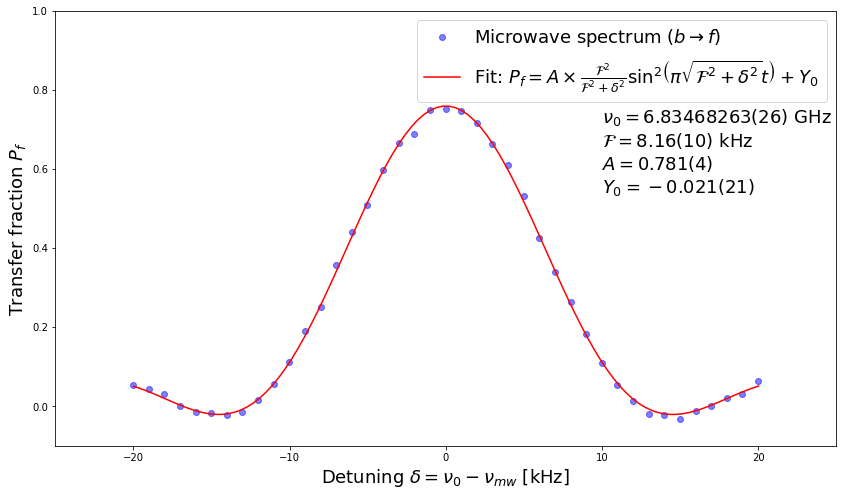

In [49]:
fig,ax = plt.subplots(figsize=(14,8))

#Make the frequency axis more readable by subtracting the large offset of 6.834... GHz
#To this end, we will define the detuning in kHz as (freq-coefs[1])/1e3
det_kHz=(freq-coefs_new[1])/1e3
det_kHz_fit=(freq_fit-coefs_new[1])/1e3

ax.plot(det_kHz,fraction,'bo',alpha=0.5,label=r'Microwave spectrum $(b\rightarrow f)$')
ax.plot(det_kHz_fit,frac_with_error_correction(freq_fit,*coefs_new) ,'-r',label=r'Fit: $P_f = A \times \frac{\mathcal{F}^2}{\mathcal{F}^2 + \delta^2} \sin^2 \left ( \pi \sqrt{\mathcal{F}^2 + \delta^2} t \right) + Y_0$ ')

#Axis limits:
ax.set_xlim(-25,25)
ax.set_ylim(-0.1,1)

#Labels:
ax.set_ylabel('Transfer fraction $P_f$',size=18)
ax.set_xlabel(r'Detuning $\delta = \nu_0 - \nu_{mw}$ [kHz]',size=18)

#Format x-axis:
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))

#Show the legend:
ax.legend(loc=1,fontsize=18)

#Text box with the fit parameters.
#Note that the statistical uncertainties have been put in by hand based on the values calculated above.
fitparam_txt = r'$\nu_0 = '+ '{:.9}(26)$ GHz\n'.format(coefs_new[1]/1e9)  + '$\mathcal{F} =' +'{:.3}(10)$ kHz\n'.format(coefs_new[0]/1e3) + '$A =' +'{:.3}$(4)\n'.format(coefs_new[2]) + '$Y_0 =' +'{:.2}$(21)\n'.format(coefs_new[3])

ax.text(0.7, 0.78, fitparam_txt, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')

#Save a PDF of the plot, e.g., for incorporation into a LaTeX document:
plt.savefig('rabi_spectrum.pdf',bbox_inches='tight') #By choosing the extension of the filename you can save the figure in different formats, .png and .pdf being the most common.

#Show the plot:
plt.show()

# Save fitted values for later:
FIT_v0 = coefs_new[1]
FIT_F = coefs_new[0]

**Export your plot to a PDF file:**

Save your final figure under the filename *rabi_spectrum.pdf*, by modifying the code that was used to export the draft figure above.

## More practice with a second data set...

If you've successfully finished analyzing the microwave spectrum (*rabispectrum.txt*), you are off to a great start!  For more practice, proceed to importing, plotting, and analyzing the data in *Bcompensation.txt*, following the instructions in the handout.

In [14]:
filename = 'Bcompensation.txt'
Ix_data, fx_data, Iy_data, fy_data, Iz_data, fz_data = np.loadtxt(filename,skiprows=1,unpack=True) #The function should automatically deal with a delimiter.
# Shift down by (FIT_v0 * 1e-6) to get the detuning in Hz
fx_data = fx_data - (FIT_v0 * 1e-6)
fy_data = fy_data - (FIT_v0 * 1e-6)
fz_data = fz_data - (FIT_v0 * 1e-6)
# fx, fy, fz are transition frequencies v_a -> v_h

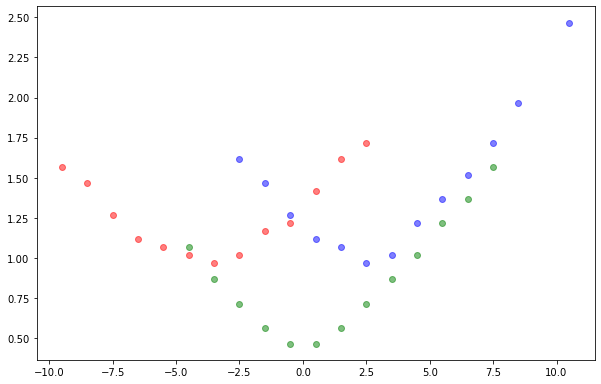

In [15]:
#Make a figure a bit bigger:
fig,ax = plt.subplots(figsize=(10,6.5))

ax.plot(Ix_data,fx_data,'bo',alpha=0.5) # alpha = 0.5 sets the opacity of the markers
ax.plot(Iy_data,fy_data,'ro',alpha=0.5) # alpha = 0.5 sets the opacity of the markers
ax.plot(Iz_data,fz_data,'go',alpha=0.5) # alpha = 0.5 sets the opacity of the markers

#Labels using latex:
# ax.set_ylabel(r'Transfer fraction',size=16)
# ax.set_xlabel(r'Microwave frequency $\nu_\mathrm{mw}$ [GHz]',size=16) #The r before the string sets to math mode

#Format x-axis:
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))

#Show the plot:
plt.show()

$$\nu_{1\rightarrow 2} = \nu_0 + \frac{\mu_1 - \mu_2}{h} |B|$$


$$\nu_{a\rightarrow h} = \nu_0 + \frac{\mu_a - \mu_h}{h} |B| = \nu_0 + (1.4 + 0.7)|B| MHz/G  = \nu_0 - 2.1|B| MHz/G$$

$$\nu_{a\rightarrow h} =  \nu_0 + 2.1|B| \frac{MHz}{G}$$

$$ B_{comp} = \beta_x I_x \hat x + \beta_y I_y \hat y + \beta_z I_z \hat z $$

$$ |B| = \sqrt{(\beta_x I_x + B_{amb, x})^2 + (\beta_y I_y + B_{amb,y})^2 + (\beta_z I_z + B_{amb,z})^2}$$

In [16]:
# When not beiong varied the currents were set to values Ix = 0 A, Iy = 0 A, Iz = 5.5 A
# frequencies in Bcompensation.txt are in MHz
# Currents are in Amperes
# state a has mu_a/h = -0.7 MHz/G and u_h/h has mu_h/h = 1.4 MHz/G
def calc_v_ah(I_vector, beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z):
    Ix = I_vector[0] # N size array of Ix values
    Iy = I_vector[1] # N size array of Iy values
    Iz = I_vector[2] # N size array of Iz values
    # Units notes: Ix, Iy, Iz must be in Amperes, B_amb_x, B_amb_y, B_amb_z must be in Gauss, beta_x, beta_y, beta_z must be in Gauss/Ampere, v_0 and v_a_h must be in Hz
    B_comp_x =  beta_x * Ix # N size array of B_comp_x values
    B_comp_y =  beta_y * Iy # N size array of B_comp_y values
    B_comp_z =  beta_z * Iz  # N size array of B_comp_z values
    total_B = np.sqrt((B_comp_x + B_amb_x)**2 + (B_comp_y + B_amb_y)**2 + (B_comp_z + B_amb_z)**2)
    v_a_h = (2.1 * total_B) # 2.1 MHz/G is the difference between mu_a/h and mu_h/h
    return v_a_h  # N size array of v_a_h values, return in MHz


In [17]:
# Now, the data we are given has current for Ix, Iy, Iz, and the resulting v_a_h frequency.
# We have already derived v0 in the previous part
# We want to solve for total ambient B in its components B_amb_x, B_amb_y, B_amb_z, and the beta values for each coil beta_x, beta_y, beta_z

# Lets try and fit all the data at once

In [18]:
# We need to pair up the data into the format [Ix, Iy, Iz, v_a_h]
# Remember that the default value for Iz is 5.5
B_comp_data_x = np.array([[[Ix_data[i], 0.0, 5.5], fx_data[i]] for i in range(len(Ix_data))])
B_comp_data_y = np.array([[[0.0, Iy_data[i], 5.5], fy_data[i]] for i in range(len(Iy_data))])
B_comp_data_z = np.array([[[0.0, 0.0, Iz_data[i]], fz_data[i]] for i in range(len(Iz_data))])
# stack them all together:
# debug sizes of data
print(B_comp_data_x.shape)
print("AHH")
B_comp_data = np.vstack([B_comp_data_x, B_comp_data_y, B_comp_data_z])

input_I_vectors = np.array([B_comp_data[i][0] for i in range(len(B_comp_data))])
output_v_a_h_frequency = np.array([B_comp_data[i][1] for i in range(len(B_comp_data))])

input_I_vectors = np.transpose(input_I_vectors)

# Confirm shapes are correct
print(input_I_vectors.shape)
print(output_v_a_h_frequency.shape)

(13, 2)
AHH
(3, 39)
(39,)


C:\Users\alexa\AppData\Local\Temp\ipykernel_17664\2186559860.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B_comp_data_x = np.array([[[Ix_data[i], 0.0, 5.5], fx_data[i]] for i in range(len(Ix_data))])
C:\Users\alexa\AppData\Local\Temp\ipykernel_17664\2186559860.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B_comp_data_y = np.array([[[0.0, Iy_data[i], 5.5], fy_data[i]] for i in range(len(Iy_data))])
C:\Users\alexa\AppData\Local\Temp\ipykernel_17664\2186559860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences

In [51]:
def plot_fitted_v_ah (beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z):
    vary_Ix_data = np.linspace(-3, 12, 201)
    vary_Iy_data = np.linspace(-11, 4, 201)
    vary_Iz_data = np.linspace(-6.5, 8.5, 201)

    vary_Ix_v_ah = [calc_v_ah([I, 0, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Ix_data]
    vary_Iy_v_ah = [calc_v_ah([0, I, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Iy_data]
    vary_Iz_v_ah = [calc_v_ah([0, 0, I], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Iz_data]

    fig, ax = plt.subplots(figsize=(15, 10))  # Increase figure size
    # Plot as a line plot
    ax.plot(vary_Ix_data, vary_Ix_v_ah, 'b-', label='Ix varying')
    ax.plot(vary_Iy_data, vary_Iy_v_ah, 'r-', label='Iy varying')
    ax.plot(vary_Iz_data, vary_Iz_v_ah, 'g-', label='Iz varying')

    # Plot actual data
    ax.plot(Ix_data, fx_data, 'bo', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iy_data, fy_data, 'ro', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iz_data, fz_data, 'go', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers

    ax.set_title('Fitted v_a_h frequency vs actual data', fontsize=24)  # Increase title font size

    # calculate rms error
    rms_error_total = 0
    for i in range(len(Ix_data)):
        rms_error_total += (calc_v_ah([Ix_data[i], 0, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fx_data[i])**2
    for i in range(len(Iy_data)):
        rms_error_total += (calc_v_ah([0, Iy_data[i], 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fy_data[i])**2
    for i in range(len(Iz_data)):
        rms_error_total += (calc_v_ah([0, 0, Iz_data[i]], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fz_data[i])**2
    rms_error_total = np.sqrt(rms_error_total / (len(Ix_data) + len(Iy_data) + len(Iz_data)))
    print(f"rms error: {rms_error_total}")

    # Labels using latex:
    ax.set_ylabel(r'$\nu_{a,h} - \nu_0$ [MHz]', size=20)  # Increase label font size
    ax.set_xlabel(r'Current [A]', size=20)  # Increase label font size

    ax.legend(fontsize=18)  # Add legend with increased font size
    ax.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size

    plt.savefig('fitted_v_ah.pdf', bbox_inches='tight')  # Save the figure
    plt.show()

seed params: [ 7.39718933 40.16876508 21.16970795 44.96297927 10.88660119 47.3569147 ]
Fit parameters with statistical uncertainties:

[[0.11319388003138307, 0.007201487026442073], [0.07993511801133744, 0.008766267546602424], [0.08654567769397567, 0.006255447890678308], [-0.19474326532580083, 0.037934977018888594], [0.2298903335121459, 0.03575011851296425], [0.001787523511147167, 0.028650285978431275]]
rms error: 0.11519645365440476


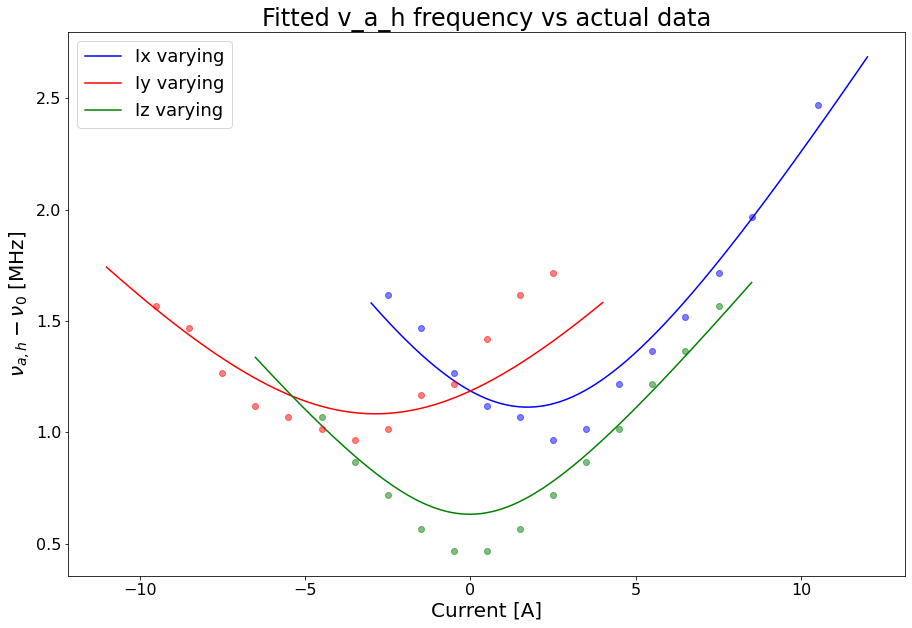

beta_x: 0.11319388003138307 with uncertainty 0.007201487026442073
beta_y: 0.07993511801133744 with uncertainty 0.008766267546602424
beta_z: 0.08654567769397567 with uncertainty 0.006255447890678308
B_amb_x: -0.19474326532580083 with uncertainty 0.037934977018888594
B_amb_y: 0.2298903335121459 with uncertainty 0.03575011851296425
B_amb_z: 0.001787523511147167 with uncertainty 0.028650285978431275


In [52]:
seed_params = np.random.rand(6)*50
print(f"seed params: {seed_params}")
B_coefficients, B_covariances = curve_fit(calc_v_ah, input_I_vectors, output_v_a_h_frequency, p0=seed_params)
print("Fit parameters with statistical uncertainties:\n")
print([[B_coefficients[n],np.sqrt(B_covariances[n,n])] for n in range(len(B_coefficients))])
plot_fitted_v_ah(B_coefficients[0], B_coefficients[1], B_coefficients[2], B_coefficients[3], B_coefficients[4], B_coefficients[5])

print(f"beta_x: {B_coefficients[0]} with uncertainty {np.sqrt(B_covariances[0, 0])}")
print(f"beta_y: {B_coefficients[1]} with uncertainty {np.sqrt(B_covariances[1, 1])}")
print(f"beta_z: {B_coefficients[2]} with uncertainty {np.sqrt(B_covariances[2, 2])}")
print(f"B_amb_x: {B_coefficients[3]} with uncertainty {np.sqrt(B_covariances[3, 3])}")
print(f"B_amb_y: {B_coefficients[4]} with uncertainty {np.sqrt(B_covariances[4, 4])}")
print(f"B_amb_z: {B_coefficients[5]} with uncertainty {np.sqrt(B_covariances[5, 5])}")

In [21]:
def calc_v_ah_with_error_correction(I_vector, beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z, A, Y_0):
    Ix = I_vector[0] # N size array of Ix values
    Iy = I_vector[1] # N size array of Iy values
    Iz = I_vector[2] # N size array of Iz values
    # Units notes: Ix, Iy, Iz must be in Amperes, B_amb_x, B_amb_y, B_amb_z must be in Gauss, beta_x, beta_y, beta_z must be in Gauss/Ampere, v_0 and v_a_h must be in Hz
    B_comp_x =  beta_x * (Ix+Y_0) # N size array of B_comp_x values
    B_comp_y =  beta_y * Iy # N size array of B_comp_y values
    B_comp_z =  beta_z * Iz  # N size array of B_comp_z values
    total_B = np.sqrt((B_comp_x + B_amb_x)**2 + (B_comp_y + B_amb_y)**2 + (B_comp_z + B_amb_z)**2)
    v_a_h = (2.1 * total_B) # 2.1 MHz/G is the difference between mu_a/h and mu_h/h
    return (v_a_h * A) + Y_0  # N size array of v_a_h values, return in MHz


In [35]:
def plot_fitted_v_ah_with_error_correction(beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z, A, Y_0):
    vary_Ix_data = np.linspace(-3, 12, 201)
    vary_Iy_data = np.linspace(-11, 4, 201)
    vary_Iz_data = np.linspace(-6.5, 8.5, 201)

    vary_Ix_v_ah = [calc_v_ah_with_error_correction([I, 0, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z, A, Y_0) for I in vary_Ix_data]
    vary_Iy_v_ah = [calc_v_ah_with_error_correction([0, I, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z, A, Y_0) for I in vary_Iy_data]
    vary_Iz_v_ah = [calc_v_ah_with_error_correction([0, 0, I], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z, A, Y_0) for I in vary_Iz_data]

    fig, ax = plt.subplots(figsize=(15, 10))  # Increase figure size
    # Plot as a line plot
    ax.plot(vary_Ix_data, vary_Ix_v_ah, 'b-', label='Ix varying')
    ax.plot(vary_Iy_data, vary_Iy_v_ah, 'r-', label='Iy varying')
    ax.plot(vary_Iz_data, vary_Iz_v_ah, 'g-', label='Iz varying')

    # Plot actual data
    ax.plot(Ix_data, fx_data, 'bo', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iy_data, fy_data, 'ro', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iz_data, fz_data, 'go', alpha=0.5)  # alpha = 0.5 sets the opacity of the markers

    ax.set_title('Fitted v_a_h frequency (with scale and shift) vs actual data', fontsize=24)  # Increase title font size

    # Labels using latex:
    ax.set_ylabel(r'$\nu_{a,h} - \nu_0$ [MHz]', size=20)  # Increase label font size
    ax.set_xlabel(r'Current [A]', size=20)  # Increase label font size

    ax.legend(fontsize=18)  # Add legend with increased font size
    ax.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size

    plt.savefig('fitted_v_ah_with_error_correction.pdf', bbox_inches='tight')  # Save the figure
    plt.show()

seed params: [0.113, 0.079, 0.086, -0.19, 0.23, 0.0, 1.0, -0.5]
Fit parameters with statistical uncertainties:

[[0.13240242868553947, 37292.882487309456], [0.11127177942112815, 31341.157236526826], [0.11163311177309528, 31442.933361002575], [-0.21896072734974983, 61673.16478804243], [0.3998947773458121, 112635.61380186175], [-0.0032682251089803265, 920.5450779487555], [1.1912085883731767, 335663.9090052936], [-0.7638061886137839, 0.07960966160101887]]


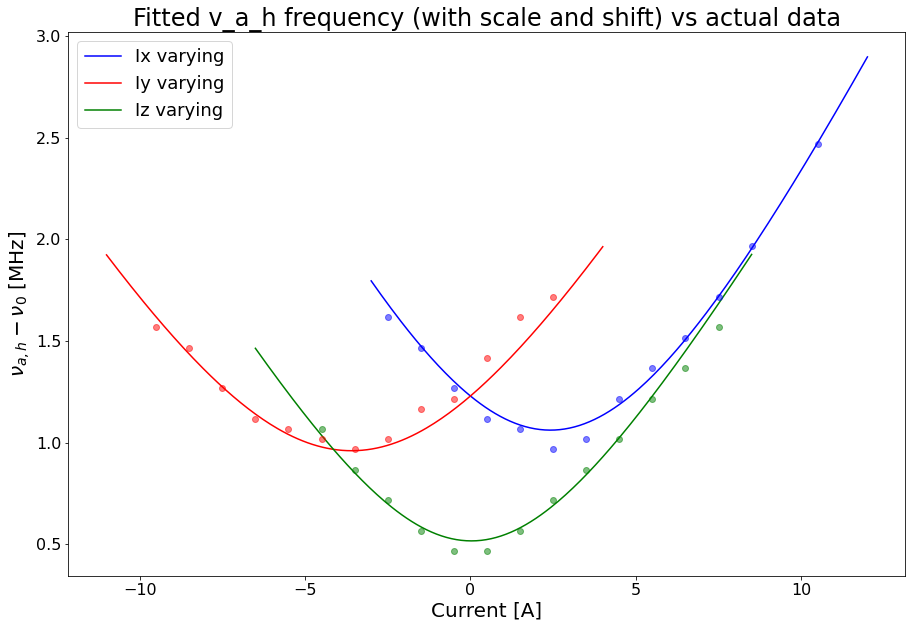

beta_x: 0.13240242868553947
beta_y: 0.11127177942112815
beta_z: 0.11163311177309528
B_amb_x: -0.21896072734974983
B_amb_y: 0.3998947773458121
B_amb_z: -0.0032682251089803265
A: 1.1912085883731767
Y_0: -0.7638061886137839


In [36]:
seed_params = [0.113, 0.079, 0.086, -0.19, 0.23, 0.00, 1.0, -0.5]
print(f"seed params: {seed_params}")
B_coefficients, B_covariances = curve_fit(calc_v_ah_with_error_correction, input_I_vectors, output_v_a_h_frequency, p0=seed_params)
print("Fit parameters with statistical uncertainties:\n")
print([[B_coefficients[n],np.sqrt(B_covariances[n,n])] for n in range(len(B_coefficients))])
plot_fitted_v_ah_with_error_correction(B_coefficients[0], B_coefficients[1], B_coefficients[2], B_coefficients[3], B_coefficients[4], B_coefficients[5], B_coefficients[6], B_coefficients[7])

print(f"beta_x: {B_coefficients[0]}")
print(f"beta_y: {B_coefficients[1]}")
print(f"beta_z: {B_coefficients[2]}")
print(f"B_amb_x: {B_coefficients[3]}")
print(f"B_amb_y: {B_coefficients[4]}")
print(f"B_amb_z: {B_coefficients[5]}")
print(f"A: {B_coefficients[6]}")
print(f"Y_0: {B_coefficients[7]}")

# Lets try fitting each dimension separately

In [50]:
def plot_fitted_v_ah_independant (beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z):
    vary_Ix_data = np.linspace(-3, 12, 201)
    vary_Iy_data = np.linspace(-11, 4, 201)
    vary_Iz_data = np.linspace(-6.5, 8.5, 201)

    vary_Ix_v_ah = [calc_v_ah([I, 0, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Ix_data]
    vary_Iy_v_ah = [calc_v_ah([0, I, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Iy_data]
    vary_Iz_v_ah = [calc_v_ah([0, 0, I], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) for I in vary_Iz_data]

    fig,ax = plt.subplots(figsize=(10,6.5))
    # Plot as a line plot
    ax.plot(vary_Ix_data, vary_Ix_v_ah, 'b-', label='Ix varying')
    ax.plot(vary_Iy_data, vary_Iy_v_ah, 'r-', label='Iy varying')
    ax.plot(vary_Iz_data, vary_Iz_v_ah, 'g-', label='Iz varying')

    # Print the data to console
    # print(vary_Ix_data[75:125:10], vary_Ix_v_ah[75:125:10])
    

    # Plot actual data
    ax.plot(Ix_data,fx_data,'bo',alpha=0.5) # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iy_data,fy_data,'ro',alpha=0.5) # alpha = 0.5 sets the opacity of the markers
    ax.plot(Iz_data,fz_data,'go',alpha=0.5) # alpha = 0.5 sets the opacity of the markers

    ax.title.set_text('Fitted v_a_h frequency (each axis fitted independantly) vs actual data')

    # calculate rms error
    rms_error_total = 0
    for i in range(len(Ix_data)):
        rms_error_total += (calc_v_ah([Ix_data[i], 0, 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fx_data[i])**2
    for i in range(len(Iy_data)):
        rms_error_total += (calc_v_ah([0, Iy_data[i], 5.5], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fy_data[i])**2
    for i in range(len(Iz_data)):
        rms_error_total += (calc_v_ah([0, 0, Iz_data[i]], beta_x, beta_y, beta_z, B_amb_x, B_amb_y, B_amb_z) - fz_data[i])**2
    rms_error_total = np.sqrt(rms_error_total / (len(Ix_data) + len(Iy_data) + len(Iz_data)))
    print(f"rms error: {rms_error_total}")

    # print actual data to console
    # print(Ix_data[:5], fx_data[:5])

    #Labels using latex:
    ax.set_ylabel(r'$\nu_{a,h} - \nu_0$ [MHz]',size=16)
    ax.set_xlabel(r'Current [A]',size=16) #The r before the string sets to math mode

    #Show the plot:
    plt.show()



seed params: [0.113, 0.079, 0.086, -0.19, 0.23, 0.0]
Fit parameters with statistical uncertainties:

[[0.1297701138315631, inf], [0.079, inf], [0.06973631798194291, inf], [-0.29626803378462746, inf], [0.08673235041295474, inf], [0.08826103161189229, inf]]


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


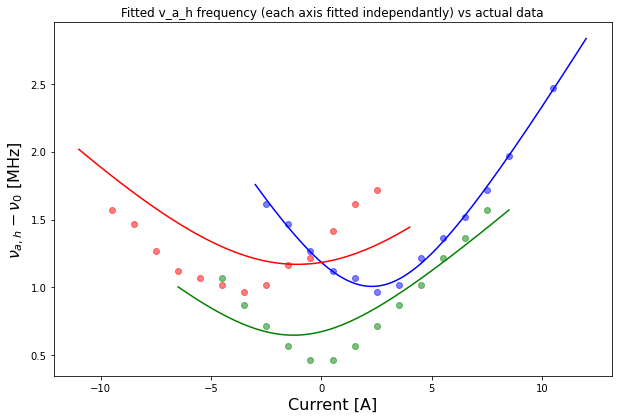

beta_x: 0.1297701138315631, beta_y: 0.079, beta_z: 0.06973631798194291, B_amb_x: -0.29626803378462746, B_amb_y: 0.08673235041295474, B_amb_z: 0.08826103161189229
Fit parameters with statistical uncertainties:

[[0.113, inf], [0.10700929548852389, inf], [0.08225277378226743, inf], [-0.14301135865218778, inf], [0.4212327113124908, inf], [-0.003950384171148039, inf]]


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


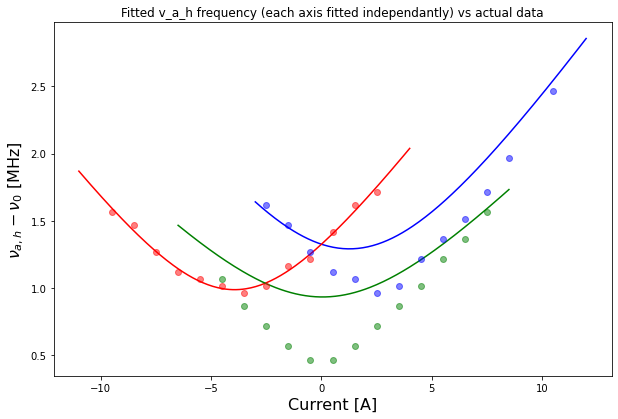

beta_x: 0.113, beta_y: 0.10700929548852389, beta_z: 0.08225277378226743, B_amb_x: -0.14301135865218778, B_amb_y: 0.4212327113124908, B_amb_z: -0.003950384171148039
Fit parameters with statistical uncertainties:

[[0.113, inf], [0.079, inf], [0.09690387154710531, inf], [-0.13688937604377366, inf], [0.1814226612176761, inf], [-0.007149448148882174, inf]]


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


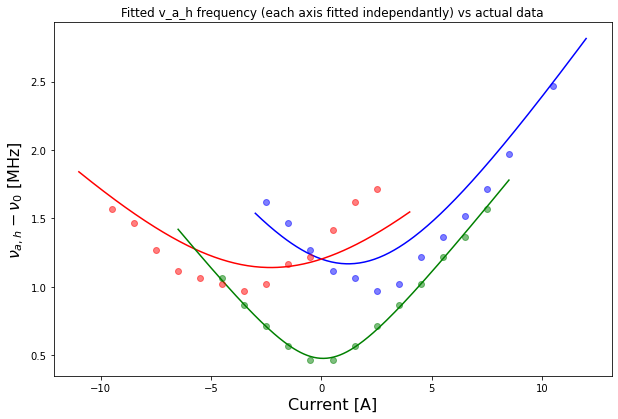

beta_x: 0.113, beta_y: 0.079, beta_z: 0.09690387154710531, B_amb_x: -0.13688937604377366, B_amb_y: 0.1814226612176761, B_amb_z: -0.007149448148882174
Together beta_x: 0.1297701138315631, beta_y: 0.10700929548852389, beta_z: 0.09690387154710531, B_amb_x: -0.29626803378462746, B_amb_y: 0.4212327113124908, B_amb_z: -0.007149448148882174


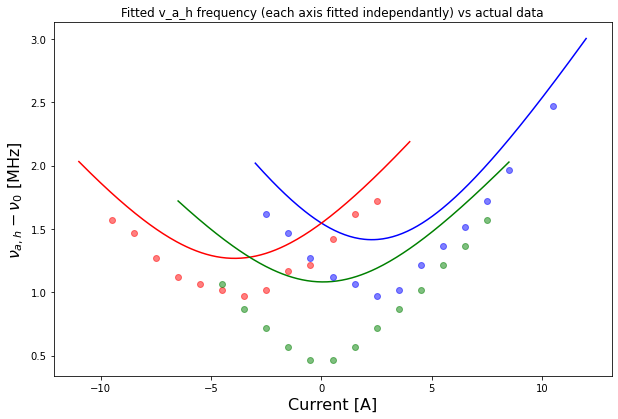

In [25]:
seed_params = [0.113, 0.079, 0.086, -0.19, 0.23, 0.00]
print(f"seed params: {seed_params}")

# For x:
B_coef_x, B_covar_x = curve_fit(calc_v_ah, input_I_vectors[:, 0:13], output_v_a_h_frequency[0:13], p0=seed_params)
print("Fit parameters with statistical uncertainties:\n")
print([[B_coef_x[n],np.sqrt(B_covar_x[n,n])] for n in range(len(B_coef_x))])
plot_fitted_v_ah_independant(B_coef_x[0], B_coef_x[1], B_coef_x[2], B_coef_x[3], B_coef_x[4], B_coef_x[5])

print(f"beta_x: {B_coef_x[0]}, beta_y: {B_coef_x[1]}, beta_z: {B_coef_x[2]}, B_amb_x: {B_coef_x[3]}, B_amb_y: {B_coef_x[4]}, B_amb_z: {B_coef_x[5]}")

# For y:
B_coef_y, B_covar_y = curve_fit(calc_v_ah, input_I_vectors[:, 13:26], output_v_a_h_frequency[13:26], p0=seed_params)
print("Fit parameters with statistical uncertainties:\n")
print([[B_coef_y[n],np.sqrt(B_covar_y[n,n])] for n in range(len(B_coef_y))])
plot_fitted_v_ah_independant(B_coef_y[0], B_coef_y[1], B_coef_y[2], B_coef_y[3], B_coef_y[4], B_coef_y[5])

print(f"beta_x: {B_coef_y[0]}, beta_y: {B_coef_y[1]}, beta_z: {B_coef_y[2]}, B_amb_x: {B_coef_y[3]}, B_amb_y: {B_coef_y[4]}, B_amb_z: {B_coef_y[5]}")

# For z:
B_coef_z, B_covar_z = curve_fit(calc_v_ah, input_I_vectors[:, 26:39], output_v_a_h_frequency[26:39], p0=seed_params)
print("Fit parameters with statistical uncertainties:\n")
print([[B_coef_z[n],np.sqrt(B_covar_z[n,n])] for n in range(len(B_coef_z))])
plot_fitted_v_ah_independant(B_coef_z[0], B_coef_z[1], B_coef_z[2], B_coef_z[3], B_coef_z[4], B_coef_z[5])

print(f"beta_x: {B_coef_z[0]}, beta_y: {B_coef_z[1]}, beta_z: {B_coef_z[2]}, B_amb_x: {B_coef_z[3]}, B_amb_y: {B_coef_z[4]}, B_amb_z: {B_coef_z[5]}")


# Together
print(f"Together beta_x: {B_coef_x[0]}, beta_y: {B_coef_y[1]}, beta_z: {B_coef_z[2]}, B_amb_x: {B_coef_x[3]}, B_amb_y: {B_coef_y[4]}, B_amb_z: {B_coef_z[5]}")

plot_fitted_v_ah_independant(B_coef_x[0], B_coef_y[1], B_coef_z[2], B_coef_x[3], B_coef_y[4], B_coef_z[5])

In [ ]:
# Plot residuals and calculate rms error
